# ML & Generating Predictions Notebook 03
This notebook is where we will evaluate baseline and candidate models to see which model we should use as our primary.  

*Note: We did not perform feature selection because the dataset contains only twelve clinically meaningful features, and removing any of them could discard useful non-linear or interaction effects. Simple correlation is not a reliable indicator of predictive value, especially in medical data. Several models we use, including Random Forests, Gradient Boosting, and regularized Logistic Regression, already perform built-in feature selection or regularization by down-weighting weaker predictors. Because these models naturally handle feature relevance, explicit feature elimination is unnecessary for this project. We will analyze feature importance in a future step* 

In [3]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# XGBoost and LightGBM
import xgboost as xgb
from xgboost import XGBClassifier


import lightgbm as lgb
from lightgbm import LGBMClassifier


# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score, 
    roc_curve,
    confusion_matrix, 
    classification_report,
    ConfusionMatrixDisplay
)

# Set plot style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Set random seed for reproducibility
np.random.seed(42)


### We will create a baseline logistic regression for our actual models to outperform

In [4]:
continuous_features = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'time']
categorical_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

In [11]:
# Load data - splits were created in previous notebook 
X_train = pd.read_csv("../data/X_train.csv")
y_train = pd.read_csv("../data/y_train.csv").values.ravel()  # Convert to 1D array

X_val = pd.read_csv("../data/X_val.csv")
y_val = pd.read_csv("../data/y_val.csv").values.ravel()  # Convert to 1D array

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Class distribution in training: {np.bincount(y_train)}")
print(f"Class distribution in validation: {np.bincount(y_val)}")

Training set: 179 samples
Validation set: 45 samples
Class distribution in training: [130  49]
Class distribution in validation: [33 12]


In [13]:
# create pipeline and run logistic regression

# Column Transformer + Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_features),
        ('cat', 'passthrough', categorical_features)
    ]
)

# Example pipeline with logistic regression, will redo this part in the ML notebook
baseline_lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear',class_weight='balanced'))]
)

In [14]:
# Train the baseline model
baseline_lr_pipeline.fit(X_train, y_train)

# Make predictions on VALIDATION set
y_val_pred = baseline_lr_pipeline.predict(X_val)
y_val_pred_proba = baseline_lr_pipeline.predict_proba(X_val)[:, 1]  # Probability of death

print("Baseline Logistic Regression trained successfully!")


Baseline Logistic Regression trained successfully!


In [18]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name="Model"):
    """
    Comprehensive evaluation function for binary classification.
    
    Prints:
    1. Accuracy - Overall correctness (misleading with imbalance)
    2. Recall (Sensitivity) - How well we catch deaths (MOST IMPORTANT clinically)
    3. Precision - Of predicted deaths, how many are real
    4. F1 Score - Harmonic mean of precision and recall
    5. ROC-AUC - Best single metric for ranking ability
    6. Confusion Matrix - Breakdown of predictions
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred : array-like
        Predicted labels (0 or 1)
    y_pred_proba : array-like
        Predicted probabilities for positive class
    model_name : str
        Name of the model for display
    """
    print("="*70)
    print(f"EVALUATION METRICS: {model_name}")
    print("="*70)
    
    # 1. ACCURACY
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print("Easy to interpret, but misleading with class imbalance")
    print("A model predicting all 'survived' would get ~73% accuracy!")
    
    # 2. RECALL (SENSITIVITY) - Most important clinically!
    recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    print(f"\nRECALL (Sensitivity): {recall:.4f} ({recall*100:.2f}%)")
    print("MOST IMPORTANT METRIC CLINICALLY")
    print("Of all patients who died, what % did we correctly identify?")
    print(f"We caught {recall*100:.1f}% of actual deaths")
    
    # 3. PRECISION
    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    print(f"\nPRECISION: {precision:.4f} ({precision*100:.2f}%)")
    print("Of all predicted deaths, what % were correct?")
    print(f"{precision*100:.1f}% of predicted deaths were real")
    
    # 4. F1 SCORE
    f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    print(f"\nF1 SCORE: {f1:.4f}")
    print("Harmonic mean of precision and recall")
    print("Good summary for imbalanced classification")
    print(f"Majority baseline: F1 = 0.0 (predicts no deaths)")
    
    # 5. ROC-AUC
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    print(f"\nROC-AUC: {roc_auc:.4f}")
    print("Measures ranking ability (0.5 = random, 1.0 = perfect)")

    
    # 6. CONFUSION MATRIX
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\nCONFUSION MATRIX:")
    print("="*50)
    print(f"True Negatives (TN):  {tn:4d}  | Correctly predicted survived")
    print(f"False Positives (FP): {fp:4d}  | Incorrectly predicted death")
    print(f"False Negatives (FN): {fn:4d}  | MISSED deaths ")
    print(f"True Positives (TP):  {tp:4d}  | Correctly predicted death")
    print("="*50)
    print(f"Total Predictions: {tn + fp + fn + tp}")
    print(f"Actual Deaths: {fn + tp} | Actual Survived: {tn + fp}")
    
    # Visualization
    print("\nVisual Confusion Matrix:")
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    ConfusionMatrixDisplay(cm, display_labels=['Survived', 'Died']).plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'Confusion Matrix: {model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Summary
    print("\n" + "="*50)
    print("SUMMARY:")
    print(f"Accuracy: {accuracy:.3f} | Recall: {recall:.3f} | Precision: {precision:.3f}")
    print(f"F1 Score: {f1:.3f} | ROC-AUC: {roc_auc:.3f}")
    print(f"Missed Deaths (FN): {fn} out of {fn+tp} ({fn/(fn+tp)*100:.1f}%)")
    print("="*50 + "\n")


EVALUATION METRICS: Baseline Logistic Regression

ACCURACY: 0.7556 (75.56%)
Easy to interpret, but misleading with class imbalance
A model predicting all 'survived' would get ~73% accuracy!

RECALL (Sensitivity): 0.5833 (58.33%)
MOST IMPORTANT METRIC CLINICALLY
Of all patients who died, what % did we correctly identify?
We caught 58.3% of actual deaths

PRECISION: 0.5385 (53.85%)
Of all predicted deaths, what % were correct?
53.8% of predicted deaths were real

F1 SCORE: 0.5600
Harmonic mean of precision and recall
Good summary for imbalanced classification
Majority baseline: F1 = 0.0 (predicts no deaths)

ROC-AUC: 0.8409
Measures ranking ability (0.5 = random, 1.0 = perfect)

CONFUSION MATRIX:
True Negatives (TN):    27  | Correctly predicted survived
False Positives (FP):    6  | Incorrectly predicted death
False Negatives (FN):    5  | MISSED deaths 
True Positives (TP):     7  | Correctly predicted death
Total Predictions: 45
Actual Deaths: 12 | Actual Survived: 33

Visual Confusio

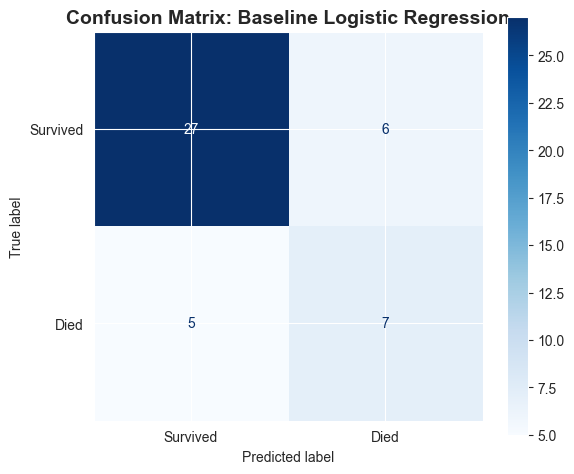


SUMMARY:
Accuracy: 0.756 | Recall: 0.583 | Precision: 0.538
F1 Score: 0.560 | ROC-AUC: 0.841
Missed Deaths (FN): 5 out of 12 (41.7%)



In [19]:
# Evaluate the Baseline Logistic Regression
evaluate_model(y_val, y_val_pred, y_val_pred_proba, model_name="Baseline Logistic Regression")


In [20]:
def plot_roc_curve(y_true, y_pred_proba, model_name="Model"):
    """
    Plot ROC curve for a single model.
    
    Parameters:
    -----------
    y_true : array-like
        True labels
    y_pred_proba : array-like
        Predicted probabilities for positive class
    model_name : str
        Name of the model for display
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'{model_name} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.500)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate (Recall)', fontsize=12)
    plt.title(f'ROC Curve: {model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return roc_auc


def plot_multiple_roc_curves(models_dict, y_true):
    """
    Plot multiple ROC curves on the same plot for comparison.
    
    Parameters:
    -----------
    models_dict : dict
        Dictionary with format: {'Model Name': y_pred_proba, ...}
    y_true : array-like
        True labels
    """
    plt.figure(figsize=(10, 8))
    
    colors = ['darkorange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    
    for i, (model_name, y_pred_proba) in enumerate(models_dict.items()):
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        color = colors[i % len(colors)]
        plt.plot(fpr, tpr, lw=2, color=color, label=f'{model_name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.500)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate (Recall)', fontsize=12)
    plt.title('ROC Curves: Model Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


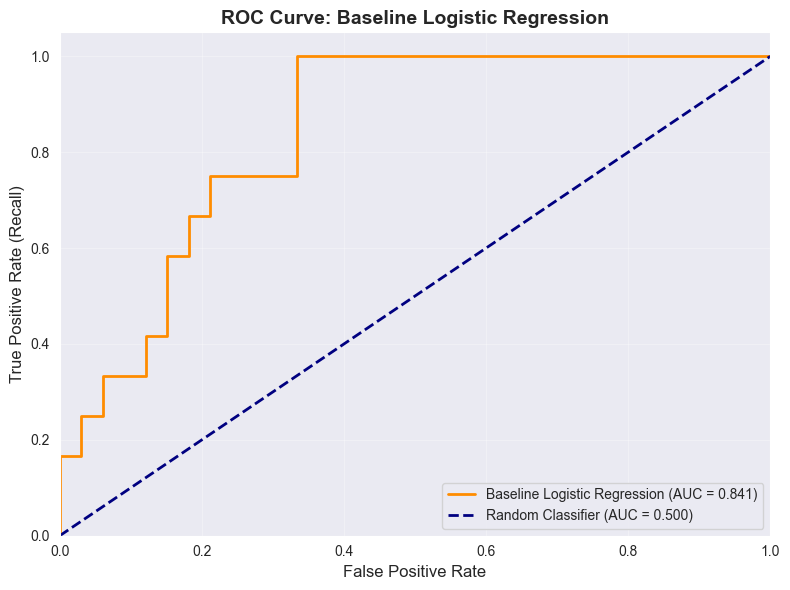

0.8409090909090909

In [21]:
# Plot ROC curve for baseline logistic regression
plot_roc_curve(y_val, y_val_pred_proba, model_name="Baseline Logistic Regression")


### Now we will use more complex models 

Notes:  
- We used 5-fold stratified cross-validation for model selection because the dataset is relatively small (299 samples). Five folds provide a good balance between bias and variance, produce stable performance estimates, and avoid the computational cost of higher-fold CV while still giving more reliable results than a single train/validation split.
- We will use GridSearchCV to return the best model for each and to tune hyperparameters

### Logistic Regression
We will begin with logistic regression. We will: 
- Tune the regularization strength of logistic regression using GridSearchCV over C ∈ {0.01, 0.1, 1, 10, 100} with 5-fold cross-validation and ROC–AUC as the scoring metric.
- Selected the C_i that produced the highest mean cross-validated ROC-AUC on thr training set.
- Refit the model with optimal C